
> *Coil field:* $$f(d) = \frac{k}{d^n}$$

> $n$ is the propagation constant

> *2D space:* $$f(x,y) = \frac{k}{(x^2+y^2)^{\frac{n}{2}}}$$

> *convert into dB:* $$RSS(d) = log(f(d))$$

> $$RSS(d) = log(k) - \frac{1}{n}log(d)$$

> $$RSS(d) = A - \frac{1}{n}log(d)$$ where $A = log(k)$

> **Trick:** use $e$ in order to avoid singularity of $f$ (a sort of saturation):

> $$f(x,y) = \frac{k}{x^2+y^2 + e}$$

> $$RSS(x,y) = A - {\frac{n}{2}}log(x^2+y^2 + e)$$

> In case of LF near field $n=3$
> $$RSS(x,y) = A - {\frac{3}{2}}log(x^2+y^2 + e)$$


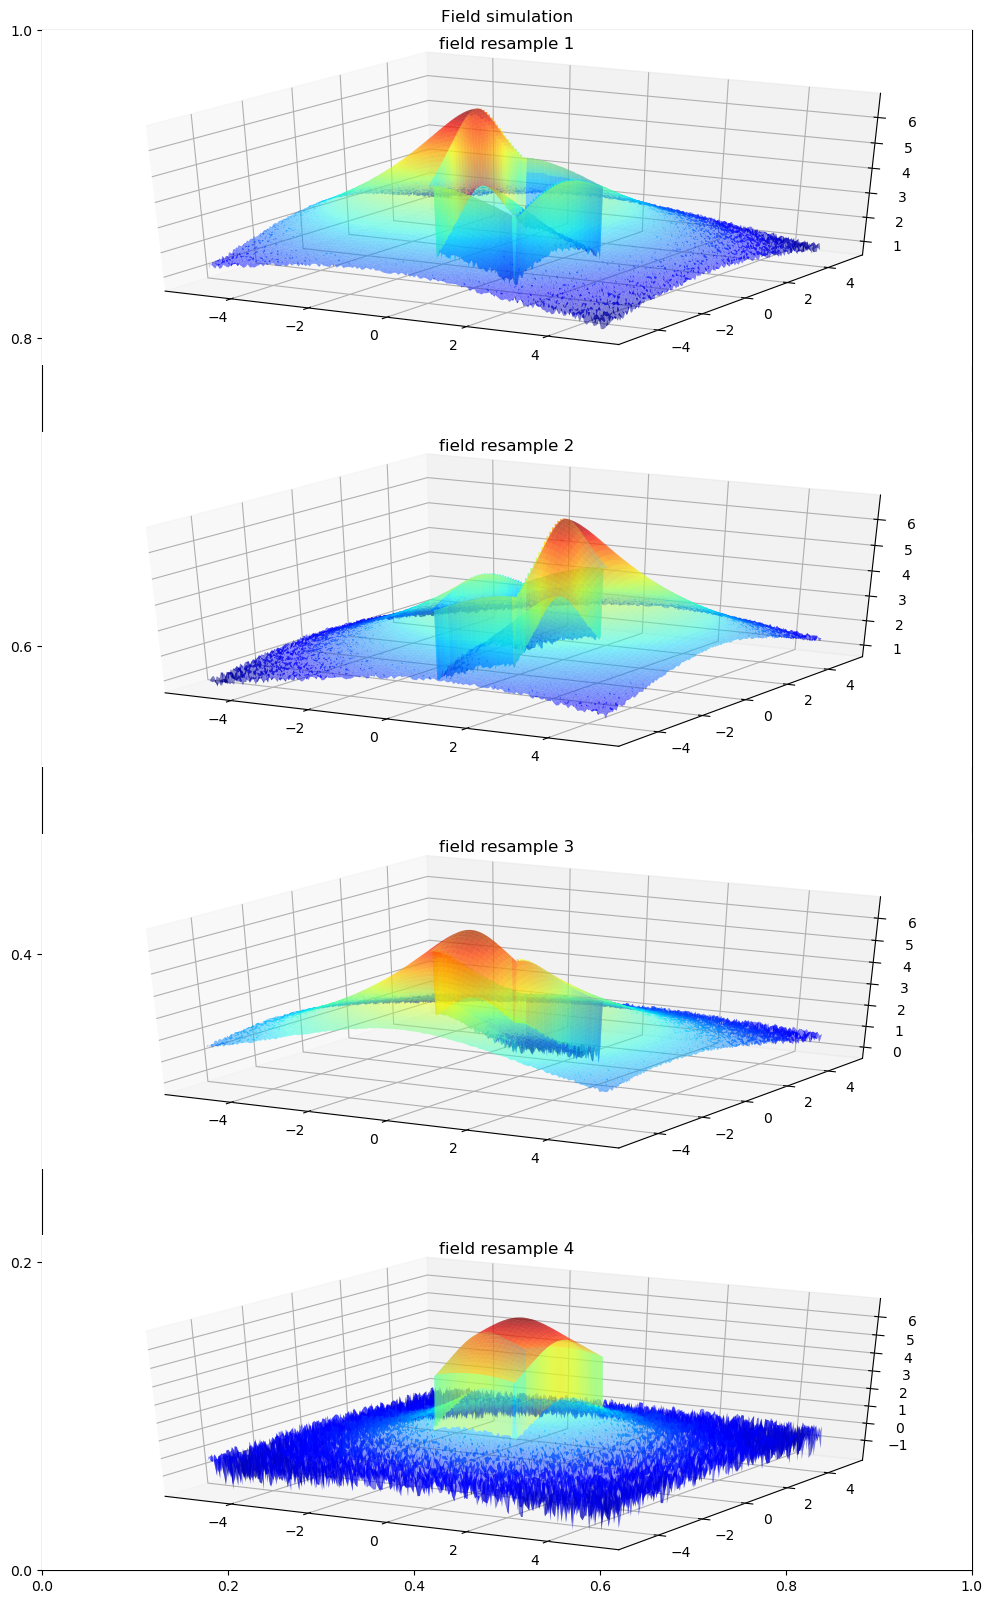

30625


In [3]:
using PyPlot
using Interpolations

Xmin = -5
Xmax = 5
Xn = 175
Ymin = -5
Ymax = 5
Yn = 175

resample_factor = 4

# sampling
x = collect(linspace(Xmin, Xmax, Xn))
xn = length(x)
y = collect(linspace(Ymin, Ymax, Yn))
yn = length(y)

println(xn*yn)

xgrid = repmat(x, 1, yn)';
ygrid = repmat(y, 1, xn);

knots = (x, y)

# resampling
xo = collect(linspace(Xmin, Xmax, Xn*resample_factor))
xno = length(xo)
yo = collect(linspace(Ymin, Ymax, Yn*resample_factor))
yno = length(yo)

xgrido = repmat(xo, 1, yno)';
ygrido = repmat(yo, 1, xno);

knots = (x, y)

type Antenna
    x::Float64
    y::Float64
end

# 
#          _
#          |
#      X1-X4--X2
#          |
#         X3
#

tg(x,y) = ((abs(x).<1) & (abs(y).<2))

antennas = Antenna[]
push!(antennas, Antenna(-1, 0))
push!(antennas, Antenna(1, 0))
push!(antennas, Antenna(0, -2))
push!(antennas, Antenna(0, 0))

N_inputs = length(antennas)

# field
field(a, x, y) = 1./(((x.-antennas[a].x).^2 .+ (y.-antennas[a].y).^2 + 1).^(3/2))

# car shape
tg(x, y) = ((abs(x).<1) & (abs(y).<2))
field_dump(a, x, y) = e.^(3*(a<4)*tg(x,y) + 3*(a>=4)*(!tg(x,y)))

# field model: car + noise
carmodel(a, x, y, noise) = (900*field(a, x, y)./field_dump(a, x, y)) .+ noise*rand(size(x))
flogv(a, x, y, noise) = log(carmodel(a, x, y, noise))

itp = []
for i = 1:N_inputs
    push!(itp, interpolate(knots, flogv(i, xgrid, ygrid, 0.1), Gridded(Linear())))
end

# _flogv(a, x, y) = itp[a][x, y]
function _flogv(a, x, y)
    z = zeros(length(x))
    for c = 1:length(x)
        z[c] = itp[a][y[c], x[c]]
        # @printf("%d, %d -> %d\n", x[c], y[c], z[c])
    end
    z = reshape(z, size(x))
end

fig = figure("An example", figsize=(12,20));
title("Field simulation")

for i=1:N_inputs
    ax = fig[:add_subplot](N_inputs, 1, i, projection = "3d");
    title("field resample $i")
    z = flogv(i, xgrid, ygrid, 1)
    ax[:plot_surface](xgrid, ygrid, z, rstride=2, cstride=2, cmap=ColorMap("jet"), alpha=0.5, linewidth=0.2)
end

In [4]:
function tg3(x, y)
    if ((abs(x)<1) && (abs(y)<2))
        return 1
    else
        if (abs(y)<2)
            if ((x>=1) && (x<2))
                return 2
            elseif ((x<=-1) && (x>-2))
                return 3
            else
                return 0
            end
        else
            if ((y<=-2) && (y>-3) && (abs(x)<2))
                return 4
            else
                return 0
            end
        end
        return 0
    end
end

function gen_datain(x, y, noise)
    len = N_inputs
    rss = Array(Float64,(length(y),0)) 
    for i in 1:len
        # no use of interpolation
        rss = hcat(rss, flogv(i, x, y, noise))
    end
    return rss
end

function gen_dataout(x, y)
    len = length(x)
    out = [tg3(x[i], y[i]) for i in 1:len]
    return out
end

function gen_rand(n)
    out = 2*5*rand(2, n)-5
    return out
end

function gen_randn(n)
    out = 2.5*randn(2, n)
    return out
end

function gen_randnx(n, y)
    out = 2.5*randn(n)'
    out = [out; y*ones(n)']
    return out
end

function gen_randny(n, x)
    out = 2.5*randn(n)'
    out = [x*ones(n)'; out]
    return out
end

function gen_linx(range, y)
    data = collect(range)'
    n = length(data)
    out = data
    out = [out; y*ones(n)']
    return out
end

function gen_liny(range, x)
    data = collect(range)'
    n = length(data)
    out = data
    out = [x*ones(n)'; out]
    return out
end

function gen_linxy(rx, ry)
    # rx=1:3;ry=1:3
    x = collect(rx)
    y = collect(ry)
    xg=(x*ones(length(y))')
    yg=(y*ones(length(x))')'
    rxg = reshape(xg,1,length(xg))
    ryg = reshape(yg,1,length(yg))
    [rxg; ryg]
    return [rxg; ryg]
end


gen_linxy (generic function with 1 method)

Interact.Options{:SelectionSlider,Float64}(Signal{Float64}(0.0, nactions=1),"y",0.0,"0.0",Interact.OptionDict(DataStructures.OrderedDict("-4.0"=>-4.0,"-3.95"=>-3.95,"-3.9"=>-3.9,"-3.85"=>-3.85,"-3.8"=>-3.8,"-3.75"=>-3.75,"-3.7"=>-3.7,"-3.65"=>-3.65,"-3.6"=>-3.6,"-3.55"=>-3.55…),Dict(3.6=>"3.6",3.85=>"3.85",1.2=>"1.2",-2.3=>"-2.3",-0.45=>"-0.45",2.0=>"2.0",1.5=>"1.5",-1.3=>"-1.3",1.45=>"1.45",3.25=>"3.25"…)),Any[],Any[],true,"horizontal")

Interact.Options{:SelectionSlider,Float64}(Signal{Float64}(5.0, nactions=1),"noise",5.0,"5.0",Interact.OptionDict(DataStructures.OrderedDict("0.0"=>0.0,"0.005"=>0.005,"0.01"=>0.01,"0.015"=>0.015,"0.02"=>0.02,"0.025"=>0.025,"0.03"=>0.03,"0.035"=>0.035,"0.04"=>0.04,"0.045"=>0.045…),Dict(5.555=>"5.555",5.215=>"5.215",6.865=>"6.865",8.725=>"8.725",9.84=>"9.84",4.075=>"4.075",8.66=>"8.66",6.785=>"6.785",0.875=>"0.875",1.19=>"1.19"…)),Any[],Any[],true,"horizontal")

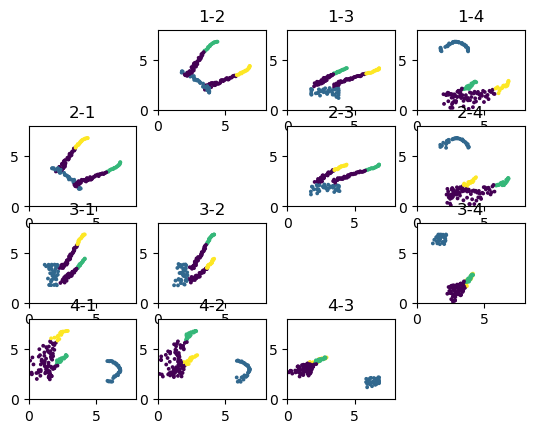

In [6]:
using Interact
using PyPlot

f = figure()
@manipulate for y = -4:0.05:4, noise = 0:.5:10
    withfig(f) do
        # Rxy = gen_randnx(N_train, y)
        Rxy = gen_linx(-4:.05:4, y)

        X_train = gen_datain(Rxy[1,:], Rxy[2,:], noise)'
        y_train = gen_dataout(Rxy[1,:], Rxy[2,:])

        subplot(4,4,4*0+2)
        title("1-2")
        scatter(X_train[1,:], X_train[2,:], c=y_train, s=3)
        xlim(0, 8); ylim(0, 8)
        subplot(4,4,4*0+3)
        title("1-3")
        scatter(X_train[1,:], X_train[3,:], c=y_train, s=3)
        xlim(0, 8); ylim(0, 8)
        subplot(4,4,4*0+4)
        title("1-4")
        scatter(X_train[1,:], X_train[4,:], c=y_train, s=3)
        xlim(0, 8); ylim(0, 8)
        subplot(4,4,4*1+1)
        title("2-1")
        scatter(X_train[2,:], X_train[1,:], c=y_train, s=3)
        xlim(0, 8); ylim(0, 8)
        subplot(4,4,4*1+3)
        title("2-3")
        scatter(X_train[2,:], X_train[3,:], c=y_train, s=3)
        xlim(0, 8); ylim(0, 8)
        subplot(4,4,4*1+4)
        title("2-4")
        scatter(X_train[2,:], X_train[4,:], c=y_train, s=3)
        xlim(0, 8); ylim(0, 8)
        subplot(4,4,4*2+1)
        title("3-1")
        scatter(X_train[3,:], X_train[1,:], c=y_train, s=3)
        xlim(0, 8); ylim(0, 8)
        subplot(4,4,4*2+2)
        title("3-2")
        scatter(X_train[3,:], X_train[2,:], c=y_train, s=3)
        xlim(0, 8); ylim(0, 8)
        subplot(4,4,4*2+4)
        title("3-4")
        scatter(X_train[3,:], X_train[4,:], c=y_train, s=3)
        xlim(0, 8); ylim(0, 8)
        subplot(4,4,4*3+1)
        title("4-1")
        scatter(X_train[4,:], X_train[1,:], c=y_train, s=3)
        xlim(0, 8); ylim(0, 8)
        subplot(4,4,4*3+2)
        title("4-2")
        scatter(X_train[4,:], X_train[2,:], c=y_train, s=3)
        xlim(0, 8); ylim(0, 8)
        subplot(4,4,4*3+3)
        title("4-3")
        scatter(X_train[4,:], X_train[3,:], c=y_train, s=3)
        xlim(0, 8); ylim(0, 8)
    end
end


Interact.Options{:SelectionSlider,Float64}(Signal{Float64}(0.0, nactions=1),"x",0.0,"0.0",Interact.OptionDict(DataStructures.OrderedDict("-4.0"=>-4.0,"-3.95"=>-3.95,"-3.9"=>-3.9,"-3.85"=>-3.85,"-3.8"=>-3.8,"-3.75"=>-3.75,"-3.7"=>-3.7,"-3.65"=>-3.65,"-3.6"=>-3.6,"-3.55"=>-3.55…),Dict(3.6=>"3.6",3.85=>"3.85",1.2=>"1.2",-2.3=>"-2.3",-0.45=>"-0.45",2.0=>"2.0",1.5=>"1.5",-1.3=>"-1.3",1.45=>"1.45",3.25=>"3.25"…)),Any[],Any[],true,"horizontal")

Interact.Options{:SelectionSlider,Float64}(Signal{Float64}(5.0, nactions=1),"noise",5.0,"5.0",Interact.OptionDict(DataStructures.OrderedDict("0.0"=>0.0,"0.005"=>0.005,"0.01"=>0.01,"0.015"=>0.015,"0.02"=>0.02,"0.025"=>0.025,"0.03"=>0.03,"0.035"=>0.035,"0.04"=>0.04,"0.045"=>0.045…),Dict(5.555=>"5.555",5.215=>"5.215",6.865=>"6.865",8.725=>"8.725",9.84=>"9.84",4.075=>"4.075",8.66=>"8.66",6.785=>"6.785",0.875=>"0.875",1.19=>"1.19"…)),Any[],Any[],true,"horizontal")

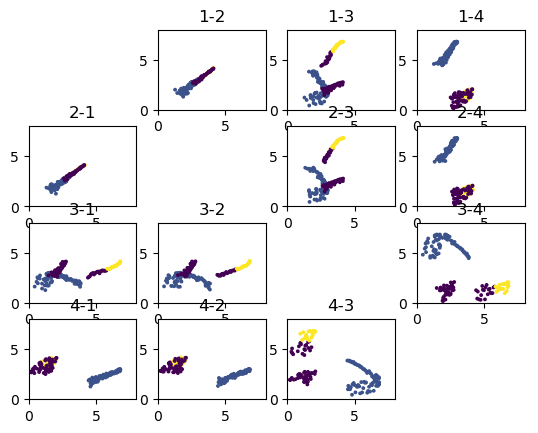

In [7]:
using Interact
using PyPlot

f = figure()
@manipulate for x = -4:0.05:4, noise = 0:.5:10
    withfig(f) do
        Rxy = gen_liny(-4:.05:4, x)

        X_train = gen_datain(Rxy[1,:], Rxy[2,:], noise)'
        y_train = gen_dataout(Rxy[1,:], Rxy[2,:])

        subplot(4,4,4*0+2)
        title("1-2")
        scatter(X_train[1,:], X_train[2,:], c=y_train, s=3)
        xlim(0, 8); ylim(0, 8)
        subplot(4,4,4*0+3)
        title("1-3")
        scatter(X_train[1,:], X_train[3,:], c=y_train, s=3)
        xlim(0, 8); ylim(0, 8)
        subplot(4,4,4*0+4)
        title("1-4")
        scatter(X_train[1,:], X_train[4,:], c=y_train, s=3)
        xlim(0, 8); ylim(0, 8)
        subplot(4,4,4*1+1)
        title("2-1")
        scatter(X_train[2,:], X_train[1,:], c=y_train, s=3)
        xlim(0, 8); ylim(0, 8)
        subplot(4,4,4*1+3)
        title("2-3")
        scatter(X_train[2,:], X_train[3,:], c=y_train, s=3)
        xlim(0, 8); ylim(0, 8)
        subplot(4,4,4*1+4)
        title("2-4")
        scatter(X_train[2,:], X_train[4,:], c=y_train, s=3)
        xlim(0, 8); ylim(0, 8)
        subplot(4,4,4*2+1)
        title("3-1")
        scatter(X_train[3,:], X_train[1,:], c=y_train, s=3)
        xlim(0, 8); ylim(0, 8)
        subplot(4,4,4*2+2)
        title("3-2")
        scatter(X_train[3,:], X_train[2,:], c=y_train, s=3)
        xlim(0, 8); ylim(0, 8)
        subplot(4,4,4*2+4)
        title("3-4")
        scatter(X_train[3,:], X_train[4,:], c=y_train, s=3)
        xlim(0, 8); ylim(0, 8)
        subplot(4,4,4*3+1)
        title("4-1")
        scatter(X_train[4,:], X_train[1,:], c=y_train, s=3)
        xlim(0, 8); ylim(0, 8)
        subplot(4,4,4*3+2)
        title("4-2")
        scatter(X_train[4,:], X_train[2,:], c=y_train, s=3)
        xlim(0, 8); ylim(0, 8)
        subplot(4,4,4*3+3)
        title("4-3")
        scatter(X_train[4,:], X_train[3,:], c=y_train, s=3)
        xlim(0, 8); ylim(0, 8)
    end
end

Interact.Options{:SelectionSlider,Float64}(Signal{Float64}(0.05, nactions=1),"noise",0.05,"0.05",Interact.OptionDict(DataStructures.OrderedDict("0.0"=>0.0,"0.005"=>0.005,"0.01"=>0.01,"0.015"=>0.015,"0.02"=>0.02,"0.025"=>0.025,"0.03"=>0.03,"0.035"=>0.035,"0.04"=>0.04,"0.045"=>0.045…),Dict(0.055=>"0.055",0.015=>"0.015",0.04=>"0.04",0.09=>"0.09",0.08=>"0.08",0.0=>"0.0",0.045=>"0.045",0.01=>"0.01",0.07=>"0.07",0.06=>"0.06"…)),Any[],Any[],true,"horizontal")

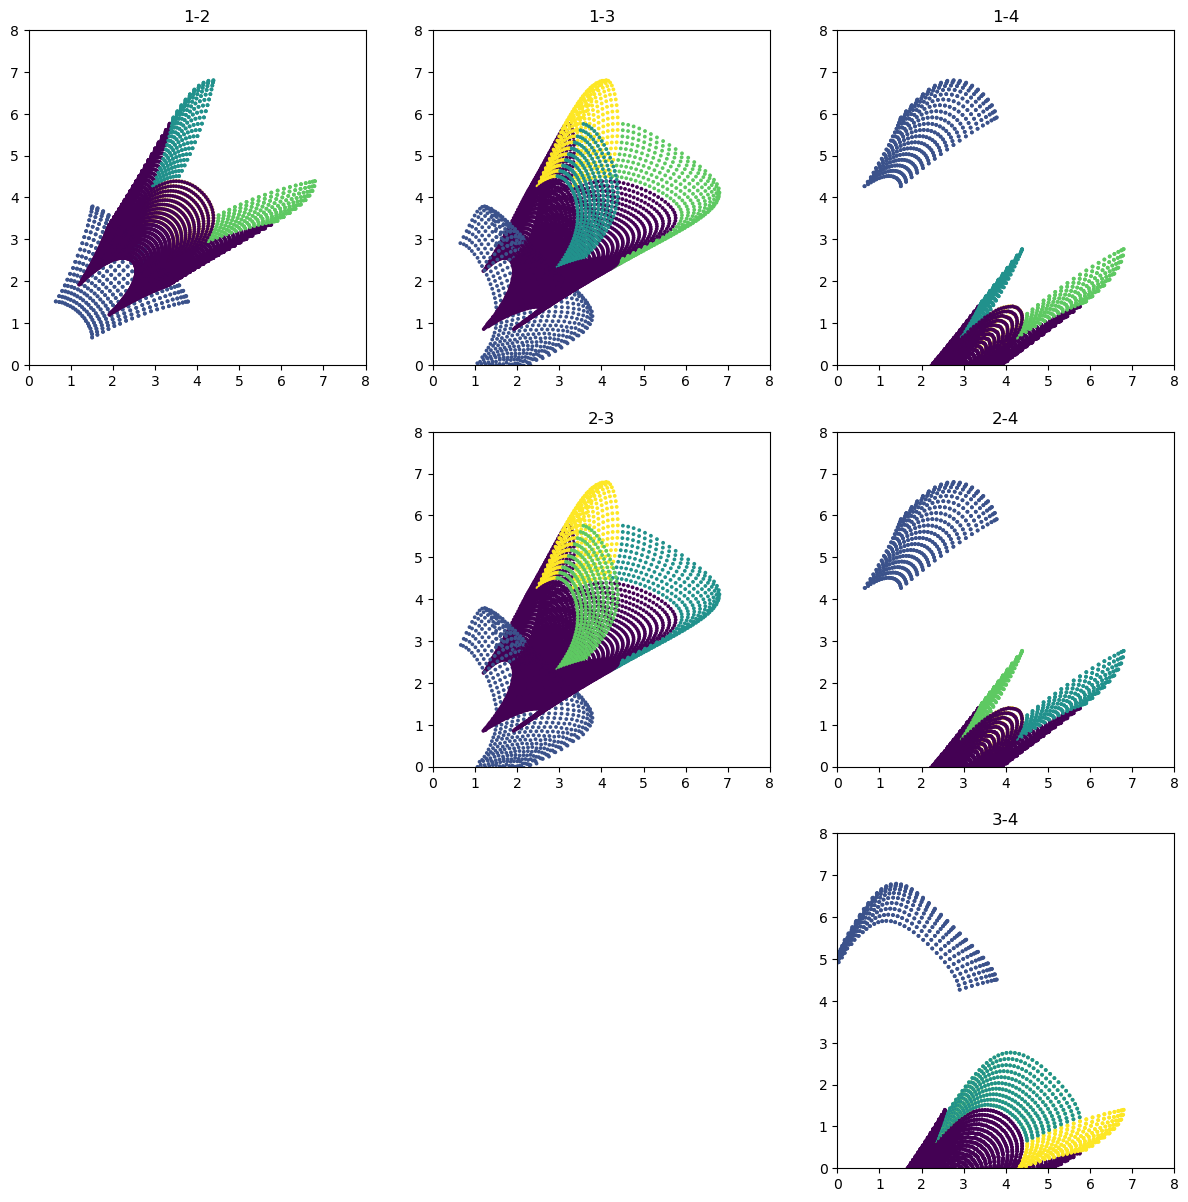

In [9]:
using Interact
using PyPlot

mx = 8
mn = 0
f = figure("An example", figsize=(20,20))
@manipulate for noise = 0:.5:10
    withfig(f) do
        Rxy = gen_linxy(-4:.1:4, -4:.1:4)

        X_train = gen_datain(Rxy[1,:], Rxy[2,:], noise)'
        y_train = gen_dataout(Rxy[1,:], Rxy[2,:])

        subplot(4,4,4*0+2)
        title("1-2")
        scatter(X_train[1,:], X_train[2,:], c=y_train, s=3)
        xlim(mn, mx); ylim(mn, mx)
        subplot(4,4,4*0+3)
        title("1-3")
        scatter(X_train[1,:], X_train[3,:], c=y_train, s=3)
        xlim(mn, mx); ylim(mn, mx)
        subplot(4,4,4*0+4)
        title("1-4")
        scatter(X_train[1,:], X_train[4,:], c=y_train, s=3)
        xlim(mn, mx); ylim(mn, mx)
        subplot(4,4,4*1+3)
        title("2-3")
        scatter(X_train[2,:], X_train[3,:], c=y_train, s=3)
        xlim(mn, mx); ylim(mn, mx)
        subplot(4,4,4*1+4)
        title("2-4")
        scatter(X_train[2,:], X_train[4,:], c=y_train, s=3)
        xlim(mn, mx); ylim(mn, mx)
        subplot(4,4,4*2+4)
        title("3-4")
        scatter(X_train[3,:], X_train[4,:], c=y_train, s=3)
        xlim(mn, mx); ylim(mn, mx)
    end
end

In [17]:
mod(2*1,2)

0